# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?
- [ ] Figure out if the white noise kernel is for ensuring the invertability of our linear system.

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [25]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim
using DelimitedFiles

In [74]:
include("../src/utils.jl")
include("../src/testfns.jl")
include("../src/kernels.jl")
include("../src/surrogates.jl")
include("../src/optimizers.jl")

optimize_surrogate (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

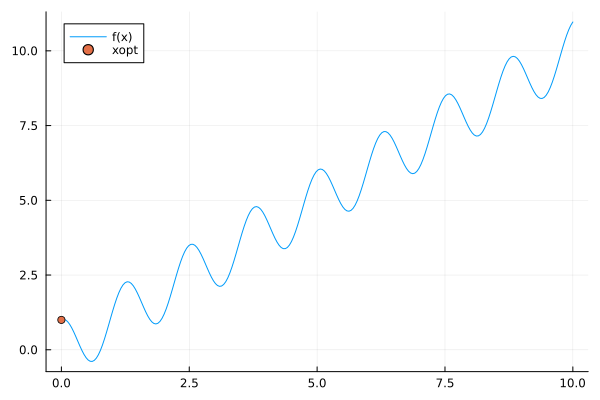

In [51]:
N, ϵ = 27, 1e-2
# testfn, testfn_name, X, y = get_toy_problem(N=N, fn_name="Rastrigin")
testfn = TestLinearPlusCosine1D(1., 5., lb=0., ub=10.)
X = randsample(N, testfn.dim, testfn.bounds[:, 1], testfn.bounds[:, 2])
y = testfn(X) .+ ϵ * randn(N)
tplot(testfn)

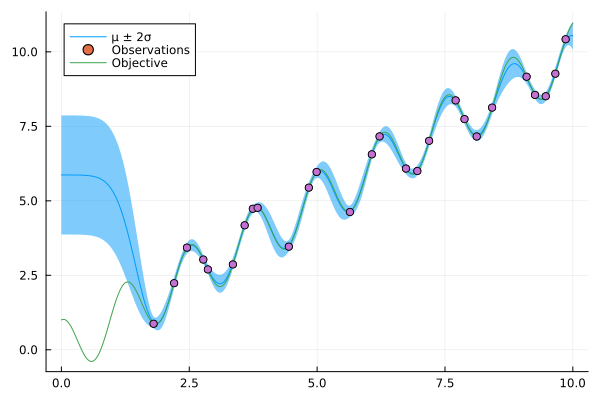

In [81]:
# kernel = Periodic(1., 1.) + SquaredExponential()
kernel = SquaredExponential()
sur = optimize_surrogate(
    gp=GP(kernel, X, y, noise=ϵ),
    kernel=SquaredExponential,
    lbs=[0.1],
    ubs=[5.],
    noise=ϵ
)

domain = get_dense_grid(testfn)
plot1d(sur, interval=domain)
plot!(domain, [testfn([x]) for x in domain], label="Objective")
scatter!(sur.X', get_observations(sur), label=nothing)

## On Computing and Optimizing Acquisition Functions

In [ ]:
βs = .5:.75:2.
UCBs = UCB_constructor(sur).(βs)
domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])

plot() # clear plot
for (j, UCB) in enumerate(UCBs)
    plot!(domain, [UCB([x]) for x in domain], label="UCB(x; β=$(βs[j]))")
end
plot!()

In [ ]:
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
results = []

for x0 in range(first(lbs) + .01, first(ubs) - .01, length=16)
    print("|")
    push!(results, optimize(
            x -> -UCB(x), lbs, ubs, [x0], Fminbox(LBFGS()), Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
    )
end

In [ ]:
xx, yy = first.(Optim.minimizer.(results)), Optim.minimum.(results)
scatter!(xx, -yy, label=nothing)

## Gaussian Process Regression for Nonlinear Time Series

In [ ]:
data = readdlm("../data/co2_mm_mlo.csv", ',');

year, month, co2 = data[2:end, 1], data[2:end, 2], data[2:end, 4];
year_month = similar(year)

# Combine year and month into a single variable where the fractional part of
# the variable represents the month
for (i, payload) in enumerate(zip(year, month))
    cur_year, cur_month = payload
    year_month[i] = cur_year + cur_month / 12.
end

xtrain = year_month[year_month.<2018]; ytrain = co2[year_month.<2018];
xtest = year_month[year_month.>=2018]; ytest = co2[year_month.>=2018];

In [ ]:
kernel = sum([
    4SquaredExponential(4.0),
    Periodic(1., 12.)*SquaredExponential(4.0,),
    RationalQuadratic(1., 1.0) + SquaredExponential(2.)
])
GP = ZeroMeanGP(kernel, xtrain', ytrain, noise=1e-3);

In [ ]:
plot1d(GP, interval=minimum(xtest):.01:maximum(xtest))

## On Modeling Separable Gaussian Processes via Additive Kernels
Given a random process $f(x) = f_1(x) + f_2(x)$, where $f_1, f_2$ are independent, then $k(x, y) = k_1(x, y) + k_2(x, y)$. Given a kernel $k: \chi^2 \to \mathbb{R}$ where $\chi \subset \mathbb{R}^d$ we know that adding a kernel or multiplying by a kernel results in another kernel.

In [ ]:
kernels = [
    SquaredExponential(.5),
    Periodic(1., 1.1),
    Periodic(.5, .5),
]
kernel = sum(kernels)
surs = []
noise = 0.

for (i, k) in enumerate(kernels)
    noise_i = Int(i - 1 <= 0) * noise
    push!(surs, ZeroMeanGP(k, X, y; noise=noise_i))
end

sur = ZeroMeanGP(kernel, X, y; noise=noise);

In [ ]:
plot1d(sur, interval=0:.01:5.)

## Experimental Below: On Automatic Differentiation of Kernel Hyperparameters
### Things to Resolve
1. There is a discrepancy between the GP fit to the sum of the kernels and the sum of the GPs fit to each kernel respectively. Investigate what is going on here.

In [ ]:
fx = zeros(length(domain))
stdx = zeros(length(domain))
normal_sample = randn()
μxs = zeros(length(surs))
σxs = zeros(length(surs))

for (i, x) in enumerate(domain)
    for (j, sur_j) in enumerate(surs)
        μxs[j], σxs[j] = sur_j([x])
    end

    μx, σx = sum(μxs), sum(σxs)

    fx[i] = μx / length(surs)
    stdx[i] = sqrt(σx)
end

p = plot(domain, fx, ribbons=2stdx, label="μ ± 2σ")
scatter!(surs[1].X', get_observations(surs[1]), label="Observations")

In [ ]:
# Let's visualize several different initializations of the squared exponential
# kernel with different lengthscales
lengthscales = [1.]
kernels = [SquaredExponential(l) for l in lengthscales]
# gram_matrix(SquaredExponential(1.), X, noise=2.)
domain = -3.:.01:3.
dk = dkernel(SquaredExponential, lengthscales)

plot()
for (i, kernel) in enumerate(kernels)
    plot!(domain, [kernel([x], [0.]) for x in domain], label="Lengthscale = $(lengthscales[i])")
    plot!(domain, [first(dk([x], [0.])) for x in domain], label="dkdθ")
    # plot!(domain, [kernel([x], [0.]) - first(dk([x], [0.])) for x in domain], label="Δ")
end
plot!()

In [ ]:
function UCB(sur::ZeroMeanGaussianProcess)
    function UCBx(x::AbstractVector; β=3.)
        μx, σx = sur(x)

        return μx + β*σx
    end

    return UCBx
end

In [ ]:
kernel2 = Periodic(.87, 3.14)
sur2 = ZeroMeanGP(kernel2, X, y, noise=1e-6);

In [ ]:
UCBx = UCB(sur)
UCBx2 = UCB(sur2)

In [ ]:
domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])

plot(domain, [UCBx([x]) for x in domain], label="UCB(x)")
plot!(domain, [UCBx2([x]) for x in domain], label="UCB2(x)")

## Delete Below

In [ ]:
using ForwardDiff

In [ ]:
ForwardDiff.gradient

In [ ]:
function SquaredExponential(lengthscales::AbstractVector)
    function squared_exponential(x, y)
        M = Diagonal(lengthscales .^ -2)
        r = x - y
        d = dot(r', M, r)
        return exp(-.5d)
    end

    return Kernel(lengthscales, squared_exponential)
end

In [ ]:
θs = [1.]

function dkernel(k_constructor::Function, θ::AbstractVector)
    ∇θ_ψ(x, y) = ForwardDiff.gradient(θ -> k_constructor(θ)(x, y), θ)
    
    return ∇θ_ψ
end

In [ ]:
dkernel(SquaredExponential, θs)([1.], [1.1])